In [ ]:
from notebook_include_fastfusion import *
# targets = {
#     "FastFusion": fastfusion_full
# }

from fastfusion.joining.simexplore import fuse_sims as fuse_sims_fastfusion
from fastfusion.joining.simexplore import fuse_sims_no_skip_invalid as fuse_sims_no_skip_invalid
from fastfusion.joining.simexplore import fuse_sims_no_combine_reservations as fuse_sims_no_combine_reservations
from fastfusion.joining.simexplore import fuse_sims_no_either as fuse_sims_no_either
# from fastfusion.simulated_annealing import fuse_sims_simulated_anneal, fuse_sims_genetic, fuse_sims_random
# import fastfusion.simulated_annealing
# fuse_sims_simulated_annealing = fastfusion.simulated_annealing.fuse_sims


def fuse_sims_optimus_mapspace(*args, **kwargs):
    return fuse_sims_fastfusion(
        *args,
        **kwargs,
        optimus_fused_group_constraint=True,
    )
    
def fuse_sims_optimus_algorithm(*args, **kwargs):
    return fuse_sims_fastfusion(
        *args,
        **kwargs,
        optimus_optimizations_only=True,
    )

results = {}

storage_filter = {
    # TensorStorage('Fmap1', "*", 1, 67108864),
    # TensorStorage('Fmap2', "*", 1, 67108864),
    # TensorStorage('Fmap3', "*", 1, 33554432),
    # TensorStorage('Fmap4', "*", 1, 33554432),
    # TensorStorage('Fmap5', "*", 1, 67108864),
    # TensorStorage('Fmap6', "*", 1, 67108864),
    # TensorStorage('Fmap7', "*", 1, 33554432),
    # TensorStorage('Fmap8', "*", 1, 33554432),
    # TensorStorage('Fmap9', "*", 1, 67108864),
}
storage_filter = storage_filter or set()

def get_gpt_shapes(batch=32, n_tokens=2048):
    # n_tokens = 128
    for parameterization, shape in [
        # ("test", dict(B=2, H=2, M=2, E=2, D=2*2, C=2, J=2, G=2)),
        # ("test", dict(B=4, H=4, M=4, E=4, D=4*4, C=4, J=4, G=4)),
        # ("test", dict(B=2, H=2, M=2, E=2, D=2*2, C=2, J=2, G=2)),
        ("6.7B", dict(B=batch, H=32, M=n_tokens, E=128, D=32*128, C=16384, J=4096, G=4096)),
        # ("13B", dict(B=batch, H=40, M=n_tokens, E=128, D=40*128, C=20480, J=5120, G=5120)),
    ]:
        downscale = 1#9999999
        shape = {k: v // downscale for k, v in shape.items()}
        shape = {k: max(1, v) for k, v in shape.items()}
        shape["D"] = shape["H"] * shape["E"]
        yield f"{parameterization} B={batch} M={n_tokens}", shape

def get_matmul_shapes():
    for parameterization, shape in [
        ("unbalanced", dict(M=8192, N1=16384, N2=4096)),
        # ("unbalanced", dict(M=32768, N1=4096, N2=2048)),
        # ("unbalanced", dict(M=32768, N1=32768, N2=128)),

        # ("balanced", dict(M=4096, N1=4096, N2=4096)),
        # ("unbalanced", dict(M=2, N1=2, N2=2)),
        # ("unbalanced", dict(M=16384, N1=8192, N2=4096)),
        # ("unbalanced", dict(M=8192, N1=8192, N2=4096)),
        # ("unbalanced", dict(M=16384, N1=16384, N2=4096)),
        # ("unbalanced", dict(M=4096, N1=16384, N2=4096)),
        # ("unbalanced", dict(M=16384, N1=4096, N2=2048)),
    ]:
        yield parameterization, shape
        
def get_batch_n_tokens_choices():
    for batch, n_tokens in [
        # (1, 1024),
        # (4, 1024),
        # (16, 1024),
        # (1, 2048),
        # (4, 2048),
        (4, 4096),
        # (16, 2048),
        # (1, 16384),
        # (4, 16384),
        # (16, 16384),
    ]:
        yield batch, n_tokens
        
exp_args = dict(
    load_inter=True,
    load_intra=True,
    storage_filter=storage_filter,
    save_results=False,
)

def iter_gpt(exp_args):
    exp_args["workload_name"] = "mha_full"
    for batch, n_tokens in get_batch_n_tokens_choices():
        for parameterization, shape in get_gpt_shapes(batch=batch, n_tokens=n_tokens):
            args = exp_args.copy()
            args["shape"] = shape
            yield parameterization, args
            
def get_matmuls_function(n_matmuls):
    def iter_matmuls(exp_args):
        exp_args["workload_name"] = f"matmuls{n_matmuls}"
        for parameterization, shape in get_matmul_shapes(): 
            args = exp_args.copy()
            args["shape"] = shape
            yield parameterization, args
    return iter_matmuls

def iter_both(exp_args):
    # yield from get_matmuls_function(1)(exp_args)
    # yield from get_matmuls_function(2)(exp_args)
    # yield from get_matmuls_function(4)(exp_args)
    # yield from get_matmuls_function(8)(exp_args)
    yield from iter_gpt(exp_args)
    # yield from get_matmuls_function(16)(exp_args)
    # yield from get_matmuls_function(32)(exp_args)
    # yield from get_matmuls_function(64)(exp_args)

# workload_generator = iter_gpt
# workload_generator = iter_matmuls4
workload_generator = iter_both

def experiment_generator():
    for parameterization, args in workload_generator(exp_args):
        for prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name in [
            # # (True, (get_optimus_tag, get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "FastFusion"),
            # # (False, (get_optimus_tag, get_layernorm_tag_mha,), filter_layernorm, fuse_sims_simulated_annealing, "Simulated Annealing"),
            # # (True, (get_optimus_tag, get_layernorm_tag_mha,), filter_optimus, fuse_sims_optimus_mapspace, "Optimus Mapspace"),
            # # (True, (get_optimus_tag, get_layernorm_tag_mha,), filter_layernorm, fuse_sims_optimus_algorithm, "Optimus Algorithm"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, None, True, "FastFusion"),
            # # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "IS", True, "IS"),
            # # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "OS", True, "OS"),
            # # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "WS", True, "WS"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "IS Pinned", True, "IS Pinned"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "OS Pinned", True, "OS Pinned"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "WS Pinned", True, "WS Pinned"),
            # # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "IS Unpinned", True, "IS Unpinned"),
            # # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "OS Unpinned", True, "OS Unpinned"),
            # # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, "WS Unpinned", True, "WS Unpinned"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, None, False, "Unfused"),
            
            (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_fastfusion, None, True, "Fastfusion"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_no_skip_invalid, None, True, "Fastfusion No Skip Invalid"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_no_combine_reservations, None, True, "Fastfusion No Combine Reservations"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_no_either, None, True, "Fastfusion No Skip Invalid Or Combine Reservations"),
            # (False, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_simulated_anneal, None, True, "Simulated Annealing"),
            # (False, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_genetic, None, True, "Genetic"),
            # (False, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_random, None, True, "Random"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_simulated_anneal, None, True, "Simulated Annealing + Pruning"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_genetic, None, True, "Genetic + Pruning"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_random, None, True, "Random + Pruning"),

        ]:
            yield parameterization, args, prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name

# for parameterization, args, prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name in experiment_generator():
#     print(f'\n' * 3)
#     print(f'Running {parameterization} {name} intra-layer exploration')
#     for k, v in args.items():
#         print(f'\t{k}: {v}')
#     exp = run_experiment(
#         name=name, 
#         callfunction=callfunc,
#         lookahead_filter=True,
#         prune_intra=prune_intra,
#         taggers=taggers,
#         fuse_function=fuse_function,
#         **args,
#         run_inter=False,
#         dataflow=dataflow,
#         fuse=fuse,
#     )
#     if getattr(exp, "intra_result", None) is None:
#         exp.load_intra_results()
#     for_name_str = [args["workload_name"], args["shape"], prune_intra] + [t.__name__ for t in taggers]
#     name_str = " | ".join(str(s) for s in for_name_str)
#     n_returned_mappings = sum(len(s.mapping.data) for sims in exp.intra_result.values() for s in sims)
#     print(f'{name_str} intra mappings: {exp.n_mappings_intra}')
#     print(f'{name_str} returned intra mappings: {n_returned_mappings}')

results = {}
key2stop_at_score = {}
key2max_evaluations = {}
speed = {}
for parameterization, args, prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name in experiment_generator():
    print(f'\n' * 3)
    print(f'Running {parameterization} {name} inter-layer exploration')
    for k, v in args.items():
        print(f'\t{k}: {v}')
    args['load_intra'] = True
    key = str((parameterization, args))
    exp = run_experiment(
        name=name, 
        callfunction=callfunc,
        lookahead_filter=True,
        prune_intra=prune_intra,
        taggers=taggers,
        fuse_function=fuse_function,
        **args,
        dataflow=dataflow,
        fuse=fuse,
        stop_at_score=key2stop_at_score.get(key, None),
        max_evaluations=key2max_evaluations.get(key, None),
    )
    if key not in key2max_evaluations:
        key2max_evaluations[key] = exp.n_mappings_inter.evaluations * 1200
        key2stop_at_score[key] = exp.n_mappings_inter.score * 1.01
    inter_result = exp.inter_result
    inter_result["EDP"] = inter_result["Energy"] * inter_result["Latency"]
    edp = inter_result["EDP"].min()
    for_name_str = [args["workload_name"], args["shape"], prune_intra] + [t.__name__ for t in taggers] + [name]
    name_str = " | ".join(str(s) for s in for_name_str)
    print(f'{name_str} intra mappings: {exp.n_mappings_intra}')
    print(f'{name_str} inter mappings: {exp.n_mappings_inter}')
    print(f'{name_str} EDP: {edp}')
    results[name_str] = exp
    speed[name] = exp.n_mappings_inter  





Running 6.7B B=4 M=4096 Fastfusion inter-layer exploration
	load_inter: True
	load_intra: True
	storage_filter: set()
	save_results: False
	workload_name: mha_full
	shape: {'B': 4, 'H': 32, 'M': 4096, 'E': 128, 'D': 4096, 'C': 16384, 'J': 4096, 'G': 4096}
Calling Accelergy in /home/timeloop-python/tests/tmp-files


Generating Single-Einsum Mappings:   0%|          | 64/17174 [00:00<03:20, 85.46it/s]

NameError: name 'explore_tile_shape' is not defined

Generating Single-Einsum Mappings:   0%|          | 64/17174 [00:19<03:20, 85.46it/s]

In [ ]:
from collections import defaultdict
import importlib
import numpy as np
import fastfusion.visualization.interactive as interactive
import fastfusion.visualization.reservationtree as looptree
from tqdm import tqdm
from IPython.display import display, SVG
importlib.reload(interactive)
importlib.reload(looptree)

import pandas as pd

to_plot = {k: exp.inter_result for k, exp in results.items()}
from fastfusion.pareto import MAPPING, STATS, TENSORS, IN_PROGRESS_STATS, MAPPING_HASH

from fastfusion.visualization.interactive import mapping2svg
# display(mapping2svg(next(iter(to_plot.values())).iloc[-1]))

# interactive.plotly_show(to_plot, "Offchip Accesses", "Occupancy", logscales=0)
interactive.plotly_show(to_plot, "Energy", "Latency", logscales=1, mapping_svg=True)
# interactive.plotly_show(to_plot, "Offchip Accesses", "Occupancy", logscales=0)

# 16s intra
# Fastfusion: 1.04 seconds
# Simulated annealing: 103.5 seconds

# 215.68T
# 19 seconds

# 26.16581k, 6
# 1.26e17, 618.4753

# 1.6e15, 3e11

# 4.36e15, 412e9

    'data': [{'line': {'shape': 'hv'},
              'marker': {'symbol': 'circl…

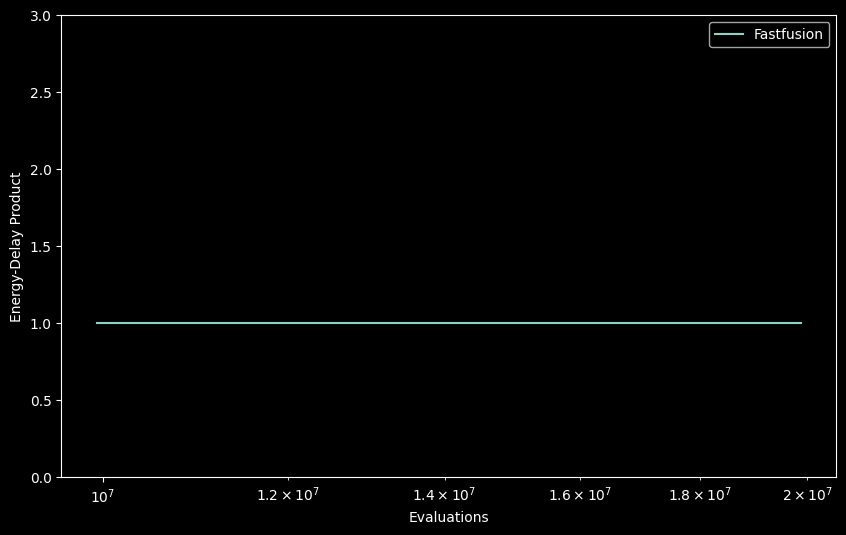

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

speed_to_plot = {k: v.history for k, v in speed.items()}
speed_to_plot = copy.deepcopy(speed_to_plot)
speed_to_plot = {k.split('|')[-1].strip(): v for k, v in speed_to_plot.items()}
speed_to_plot = {k: v for k, v in list(speed_to_plot.items())[::-1]}
fastfusion_min_score = min(v[1] for v in speed_to_plot["Fastfusion"])
fastfusion_n_evaluations = max(x[0] for x in speed_to_plot["Fastfusion"])
# Make sure all scores are >= fastfusion_min_score
for k, v in speed_to_plot.items():
    v = [(x[0], max(x[1], fastfusion_min_score)) for x in v]
    speed_to_plot[k] = v

# Normalize to fastfusion
for k, v in speed_to_plot.items():
    v = [(x[0], x[1] / fastfusion_min_score) for x in v]
    speed_to_plot[k] = v

# fastfusion_n_evaluations = min(x[0] for x in speed_to_plot["Fastfusion"])
# Remove inf values
inf = float("inf")
speed_to_plot = {k: list(filter(lambda x: x[1] != inf, v)) for k, v in speed_to_plot.items()}
max_evaluations = max(max(v2[0] for v2 in v) for v in speed_to_plot.values())
if max_evaluations == fastfusion_n_evaluations:
    max_evaluations *= 2
min_score = min(min(v2[1] for v2 in v) for v in speed_to_plot.values())
for k, v in speed_to_plot.items():
    v.append((max_evaluations, v[-1][1]))
# History is a list of tuples (score, evaluations)
fig, ax = plt.subplots(figsize=(10, 6))
for k, v in speed_to_plot.items():
    v = np.array(v)
    ax.plot(v[:, 0], v[:, 1], label=k)
ax.set_xlabel("Evaluations")
ax.set_ylabel("Energy-Delay Product")
# ax.set_yscale("log")
# ax.set_xlim(left=fastfusion_n_evaluations / 10, right=max_evaluations)
ax.set_ylim(bottom=0, top=min_score * 3)
ax.set_xscale("log")
ax.legend()

5439
20757
25877
38216
87104
93902


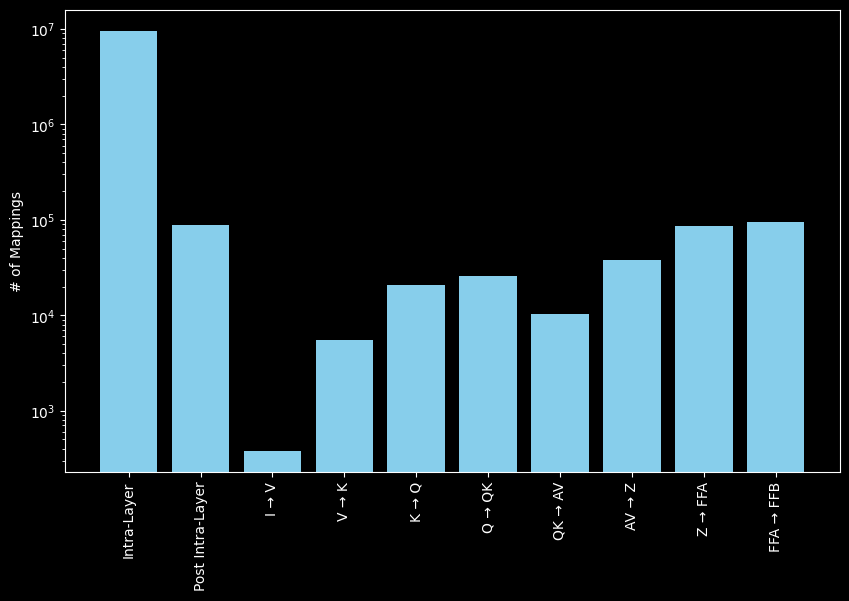

In [ ]:
v = next(iter(results.values())).n_mappings_inter.n_mappings

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(v.keys(), v.values(), color='skyblue')

values = list(v.values())
for i, value in enumerate(values):
    if i > 0 and values[i] > values[i-1]:
        print(values[i])

# Set logarithmic scale for Y-axis
plt.yscale('log')

# Add labels and title
plt.ylabel('# of Mappings')

# Rotate X-axis labels vertically
plt.xticks(rotation=90)

# Show the plot
plt.show()